# Association Analysis of Filipino Cuisine Ingredients

## Data loading and preview

### Read JSON files

In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.allrecipes.com/recipe/128699/famous-chicken-adobo/',
 'name': 'Famous Chicken Adobo',
 'ingredients': ['2 tablespoons vegetable oil',
  '1 (3 pound) chicken, cut into pieces',
  '1 large onion, quartered and sliced',
  '2 tablespoons minced garlic',
  ' 2/3  cup low sodium soy sauce',
  ' 1/3  cup white vinegar',
  '1 tablespoon garlic powder',
  '2 teaspoons black pepper',
  '1  bay leaf'],
 'instructions': ['Step 1: Heat vegetable oil in a large skillet over medium-high heat. Cook chicken pieces until golden brown, 2 to 3 minutes per side. Transfer chicken to a plate and set aside.',
  'Step 2: Add onion and garlic to the skillet; cook until softened and brown, about 6 minutes.',
  'Step 3: Pour in soy sauce and vinegar and season with garlic powder, black pepper, and bay leaf.',
  'Step 4: Return chicken to pan, increase heat to high, and bring to a boil. Reduce heat to medium-low, cover, and simmer until chicken is tender and cooked through, 35 to 40 minutes.'

### Convert JSON to DataFrame

In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.allrecipes.com/recipe/128699/famou...,Famous Chicken Adobo,"[2 tablespoons vegetable oil, 1 (3 pound) chic...",[Step 1: Heat vegetable oil in a large skillet...
1,https://www.allrecipes.com/recipe/212994/pinak...,Pinakbet,"[3 tablespoons olive oil, 1 onion, chopped, 2...",[Step 1: Heat oil in a large pot over medium h...
2,https://www.allrecipes.com/recipe/204958/pork-...,Pork Sinigang,"[1 tablespoon vegetable oil, 1 small onion, ch...",[Step 1: Heat vegetable oil in a skillet over ...
3,https://www.allrecipes.com/recipe/270708/lumpi...,Lumpia in the Air Fryer,"[1 pound Italian hot sausage links, 1/2 cup f...",[Step 1: Remove casing from sausage and cook i...
4,https://www.allrecipes.com/recipe/212911/filip...,Filipino Beef Steak,"[4 pounds New York strip steak, sliced thin, 1...",[Step 1: Place sliced beef in a large bowl. Wh...


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          4244 non-null   object
 1   name          3898 non-null   object
 2   ingredients   3896 non-null   object
 3   instructions  3872 non-null   object
dtypes: object(4)
memory usage: 132.8+ KB


### Display some statistics

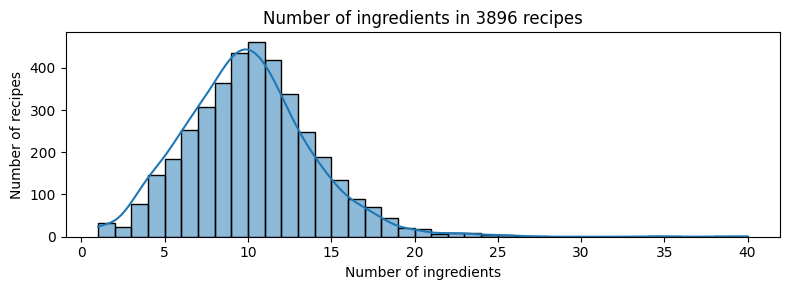

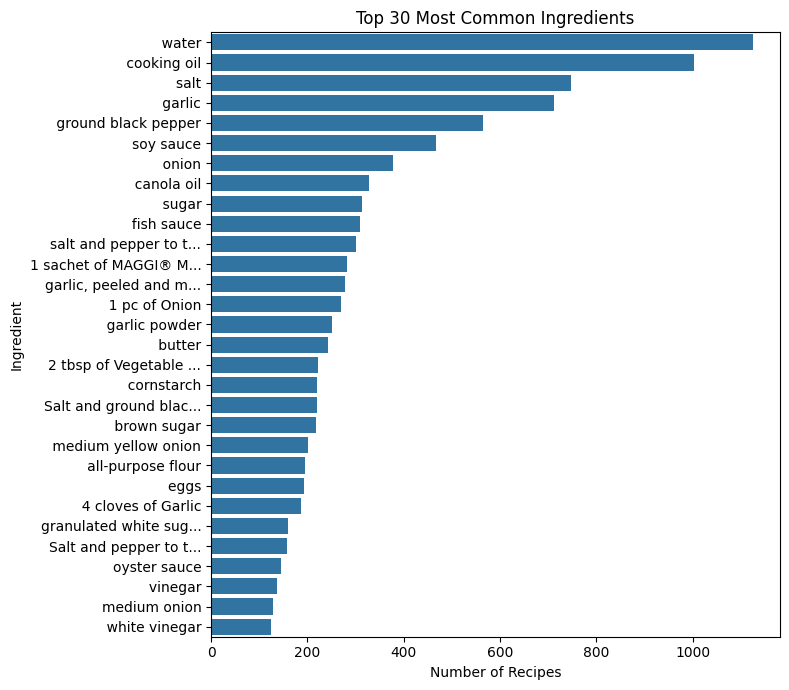

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Step 1. Remove recipes with no ingredients

In [5]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

Dropped 348 rows.


In [6]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(recipe_df.ingredients, path="data/preprocess/0_raw.txt")

### Step 2. Clean ingredient format

In [7]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 63717.57it/s]


In [8]:
save_ingredients(recipe_df.cleaned, path="data/preprocess/1_cleaned.txt")

### Lemmatize words and remove non-ingredient words

In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

100%|██████████| 3896/3896 [02:17<00:00, 28.41it/s]


In [10]:
save_ingredients(recipe_df.lemmatized, path="data/preprocess/2_lemmatized.txt")

### Remove stop words related to culinary

In [11]:
with open(f"data/stopwords.txt", encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 16438.95it/s]


In [12]:
save_ingredients(recipe_df.filtered, path="data/preprocess/3_filtered.txt")

### Standardize ingredient names at word level

In [13]:
# TODO: Separate thesaurus for word and phrase level
with open("data/thesaurus.json", encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 3896/3896 [00:00<00:00, 259752.16it/s]


In [14]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess/4_standardized_word.txt",
)

### Remove duplicate terms

In [15]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

100%|██████████| 3896/3896 [00:00<00:00, 23469.96it/s]


In [16]:
save_ingredients(recipe_df.filtered, path="data/preprocess/5_unique.txt")

### Standardize ingredient names at phrase level

In [17]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

100%|██████████| 3896/3896 [00:00<00:00, 487049.82it/s]


In [18]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess/6_standardized_phrase.txt",
)

### Break down ingredients into basic components

In [19]:
with open("data/components.json", encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

100%|██████████| 3896/3896 [00:00<00:00, 389637.53it/s]


In [20]:
save_ingredients(recipe_df.components, path="data/preprocess/7_components.txt")

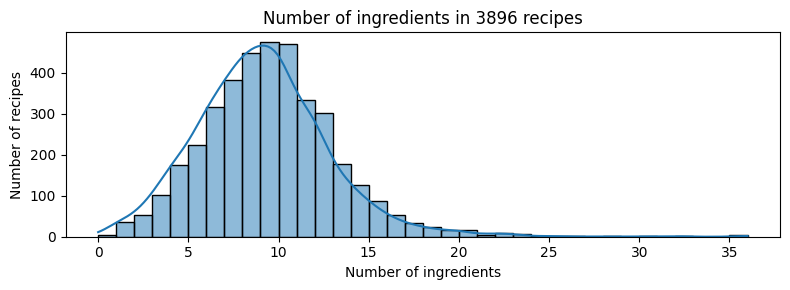

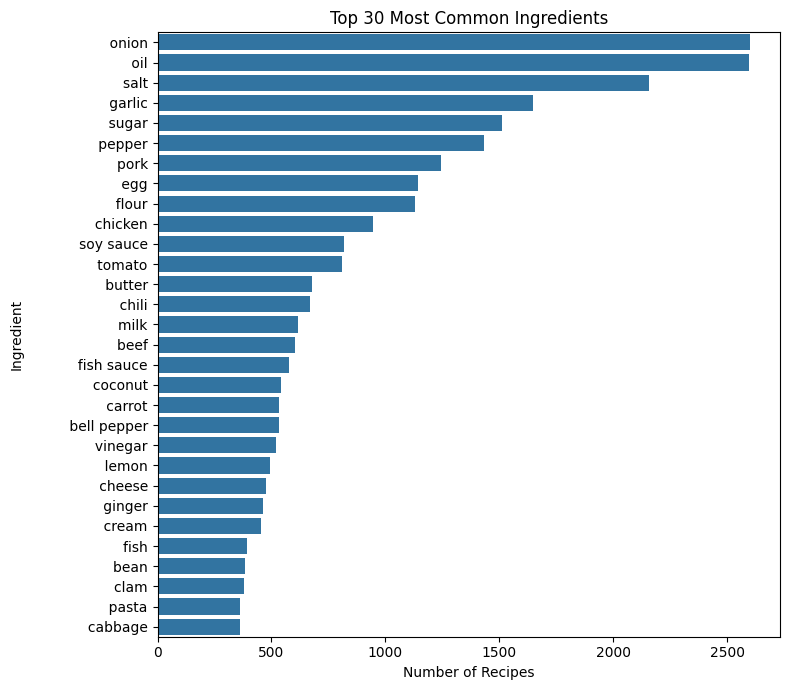

In [21]:
plot_ingredient_count_distribution(recipe_df.components)
plot_common_ingredients(recipe_df.components)

### Save preprocessed data

In [24]:
cols_to_save = ["link", "name", "components"]
recipe_df[cols_to_save].to_csv("data/preprocessed_recipes.csv", index=False)